In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("AEP_hourly.csv")

In [8]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [9]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [11]:
df.shape


(121273, 2)

In [12]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [13]:
import seaborn as sns

In [16]:
df = df.set_index("Datetime")

In [19]:
color_pal = sns.color_palette()

In [21]:
df.index = pd.to_datetime(df.index)

<Axes: xlabel='Datetime'>

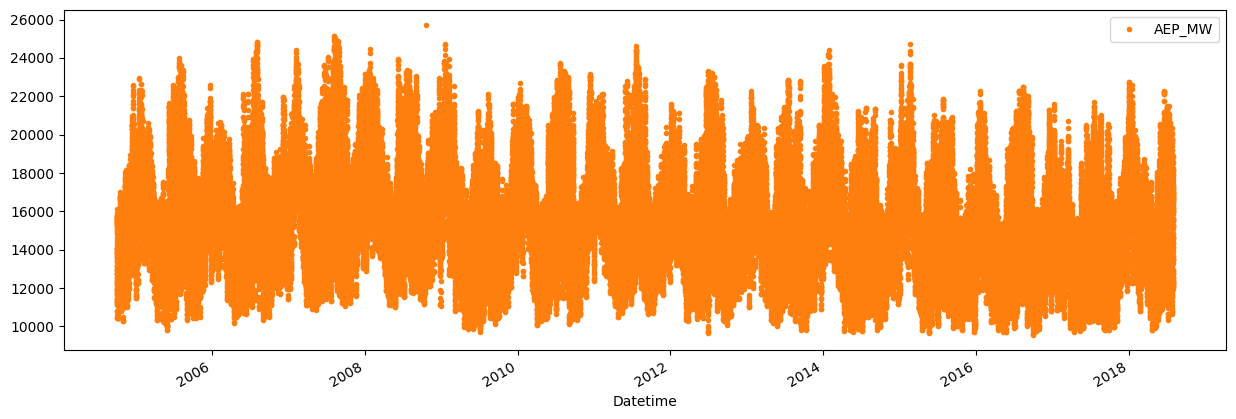

In [22]:
df.plot(style='.',figsize=(15,5),color = color_pal[1])

In [23]:
train = df.iloc[df.index<'01-01-2015']
test = df.iloc[df.index >= '01-01-2015']

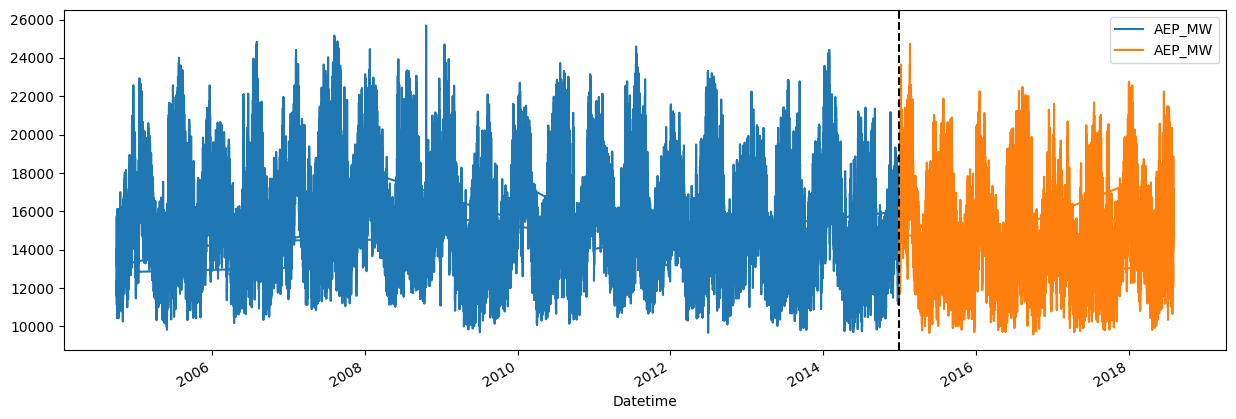

In [29]:
fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax)
test.plot(ax=ax)
ax.axvline("01-01-2015",color = "black",ls = "--")

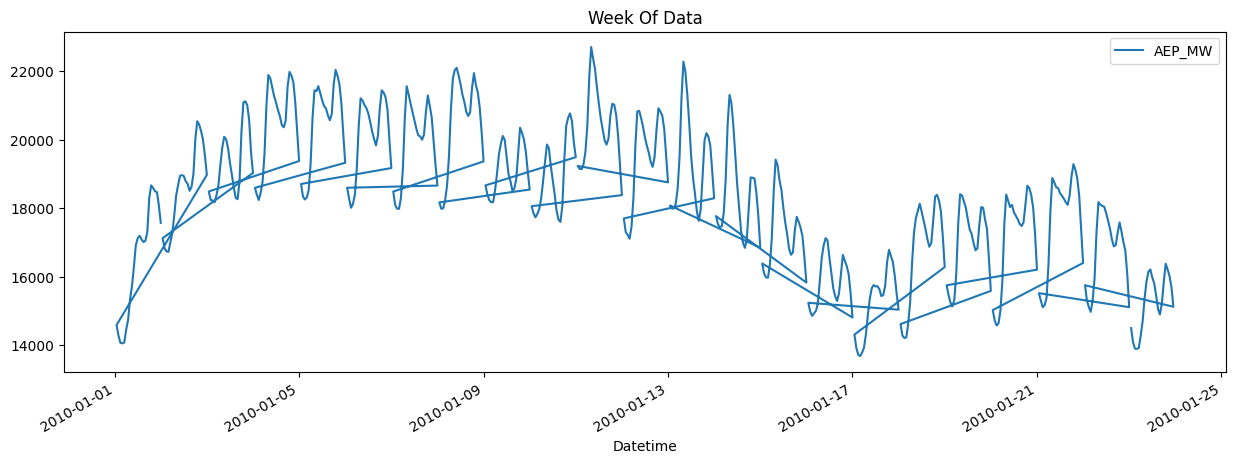

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-24-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

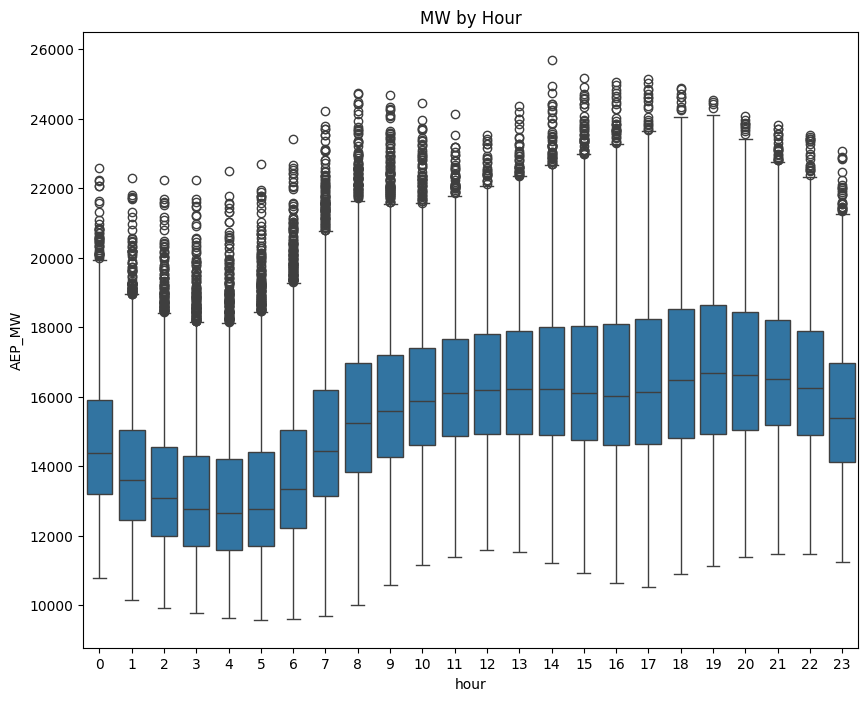

In [38]:

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_18464\3087536141.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')


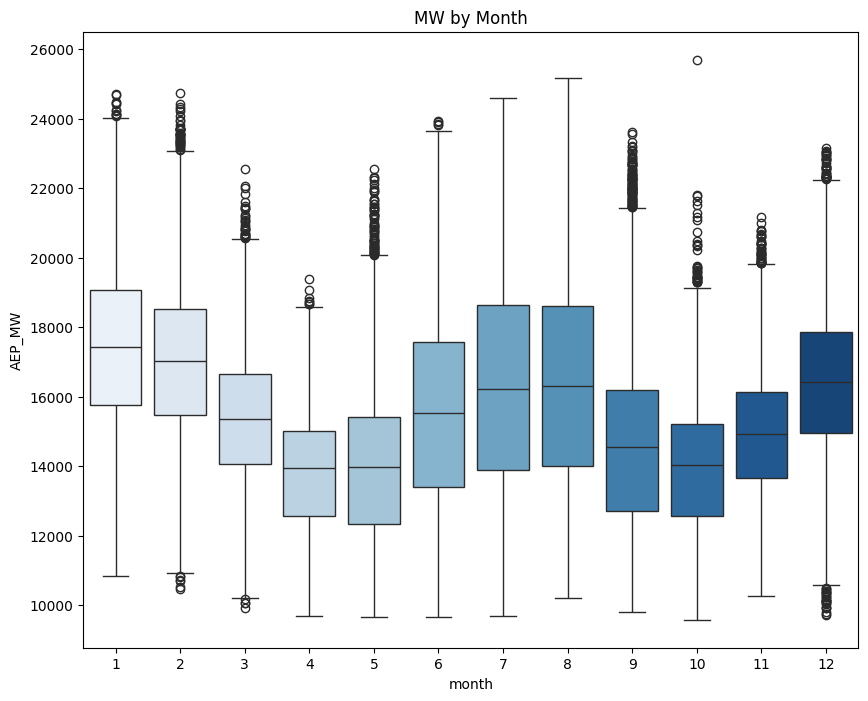

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [40]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [48]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=0)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [49]:
reg.feature_importances_

array([0.1564464 , 0.3096922 , 0.24938919, 0.06898549, 0.15248886,
       0.06299786], dtype=float32)

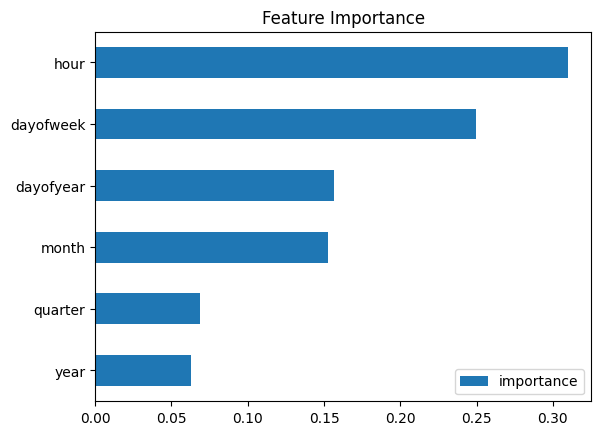

In [45]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

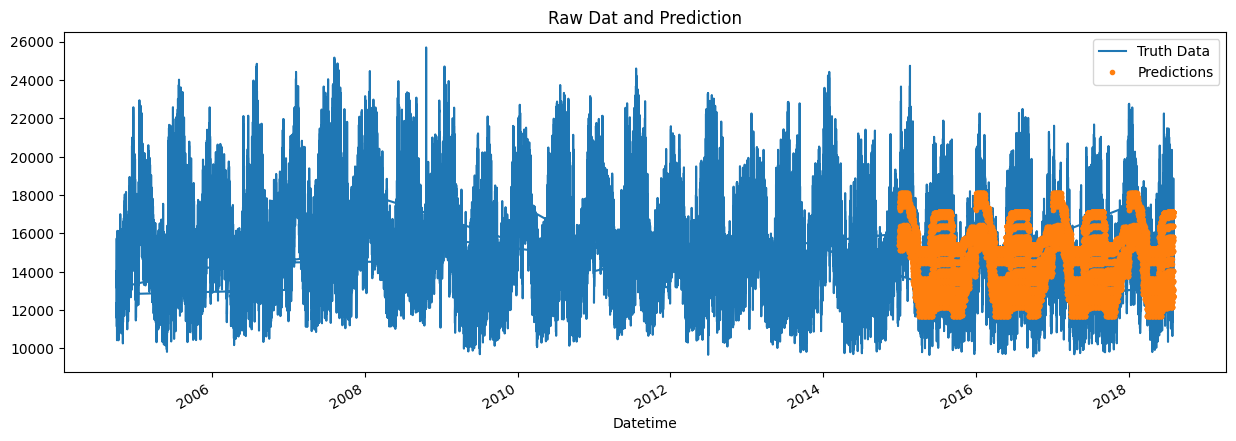

In [47]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

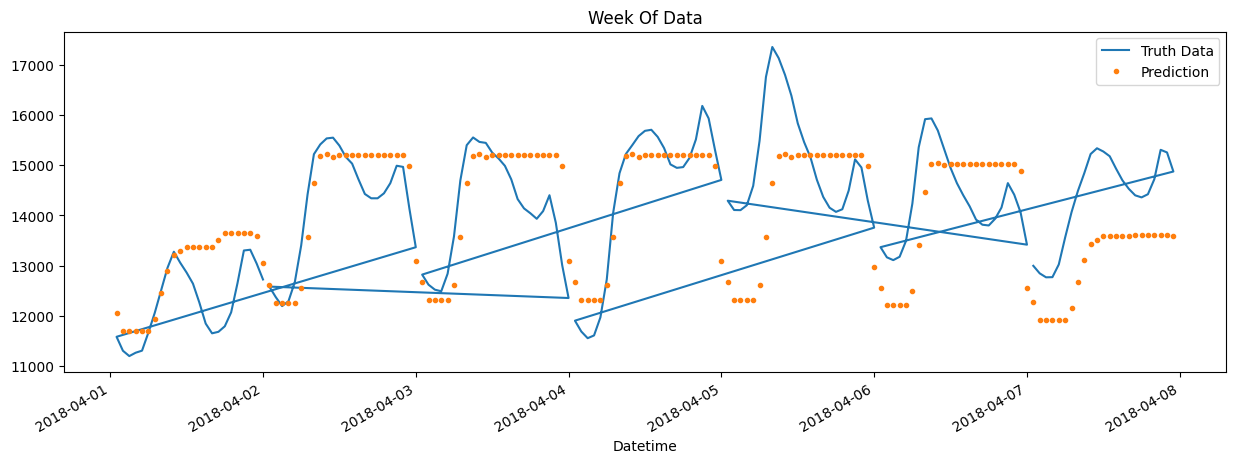

In [51]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [53]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1649.42


In [54]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    5630.352132
2015-02-20    5394.673665
2018-01-06    4823.354574
2015-01-08    4703.830404
2015-12-25    4415.192912
2015-02-16    4411.147461
2015-12-24    4138.202759
2015-02-15    4079.741536
2018-01-05    4044.314657
2018-01-07    4037.638062
Name: error, dtype: float64